## CrowdED: Crowdsourcing task optimization
---
The research question we aim to answer is: "Can we a-priori estimate optimal workers and tasks' assignment to obtain maximum accuracy on all tasks?"

*This notebook takes step by step the construction of the crowdED module*

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

---
### Data preparation: Tasks and Workers Dataframe Construction

In [7]:
total_tasks = 415 #342 #100

In [8]:
total_workers = 40 #50 #30

In [9]:
p_hard_tasks = 0.4

Next, we randomly assign (without [replacement](https://www.ma.utexas.edu/users/parker/sampling/repl.htm)) which tasks easy/hard based on the proportions specified.

#### Tasks and True Answers (Gold)

In our simulation, the task is that the worker has to choose one out of the five given answers. Here, we simulate the true answer for each worker-task pair.

It is needed one of the keys for the answer

In [1]:
import sys
import numpy as np
import pandas as pd
import shortuuid as uid
from random_words import RandomWords

KEYS = 7
HARD = 0.2
LEN = 6
N = 10

class Tasks(object):
    def __init__(self, keys=KEYS, length=LEN):
        self.length = length
        self.keys = keys
    
    def _generate_tasks(self, n=N):
        return ['task_'+uid.ShortUUID().random(length=self.length) for i in range(n)]
    
    def _random_words(self):
        key = RandomWords().random_words(count=self.keys)
        #print('Generated Random Key: {}\n'.format(key))
        return key
    
    def _true_answer(self, n=N):
        return [answer for answer in np.random.choice(self._random_words(), n)]
    
    def create(self, n=N, h=HARD):
        e = 1-h; cut_tasks = 0.75#; print('Percentage of Hard Tasks: {}'.format(HARD))
        tasks = self._generate_tasks(n)
        probs_tasks = []
        easy_tasks = [task for task in np.random.choice(tasks, int(round(e*n,0)), replace=False)]
        hard_tasks = [task for task in set(tasks)-set(easy_tasks)]
        df = pd.DataFrame()
        #df['task_id'] = tasks
        df['true_answers'] = self._true_answer(n)
        df.index = tasks
        df['label_task'] = ['hard_task' if tasks[i] in hard_tasks else 'easy_task' for i in range(n)]
        for i in df['label_task']:
            if i == 'easy_task': #uniform from .75 to 1
                probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
            elif i == 'hard_task': #uniform from .5 to .75
                probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
            else: probs_tasks.append(1)
        
        df['prob_task'] = [item for prob in probs_tasks for item in prob]
        return df

In [11]:
df_tasks = Tasks(5).create(total_tasks, p_hard_tasks)
df_tasks.head()

,true_answers,label_task,prob_task
task_pdS8zH,medals,easy_task,0.93
task_Me2SrQ,medals,easy_task,0.85
task_ajyKEV,medals,easy_task,0.78
task_8qQ8Tk,components,easy_task,0.92
task_UVySyX,comments,easy_task,0.87


In [12]:
df_tasks.index

Index(['task_pdS8zH', 'task_Me2SrQ', 'task_ajyKEV', 'task_8qQ8Tk',
       'task_UVySyX', 'task_YW99Z9', 'task_TRyGBV', 'task_e3yJKu',
       'task_n9WY2W', 'task_UKgMX2',
       ...
       'task_4Upe7W', 'task_qmfpMN', 'task_eGEqdj', 'task_NqdSFq',
       'task_jVvH4f', 'task_9HPfF6', 'task_DHU5YS', 'task_y7q5dM',
       'task_Nuxq4B', 'task_NUPKsT'],
      dtype='object', length=415)

### Workers and Distribution

In [2]:
import sys
import pandas as pd
import shortuuid as uid
from scipy.stats import beta

LEN = 6
N = 10
a = 5 #10
b = 1

class Workers(object):
    def __init__(self, alpha=a, beta=b, length=LEN):
        self.length = length
        self.alpha = alpha
        self.beta = beta
        
    def create(self, n=N):
        df = pd.DataFrame({'prob_worker':beta.rvs(self.alpha, self.beta, size=n)})
        df.index = [uid.ShortUUID().random(self.length) for i in range(n)]
        return df

In [14]:
df_workers = Workers().create(total_workers)
df_workers.head()

,prob_worker
ZgKoxZ,0.899058
oev8At,0.985305
4eEAjG,0.719079
dXFwEU,0.938139
QswzdS,0.424661


In [15]:
df_workers.index

Index(['ZgKoxZ', 'oev8At', '4eEAjG', 'dXFwEU', 'QswzdS', 'd9s8F4', 'amhSxX',
       '4GiQsL', 'pnkanh', 'vdWqpq', 'WJo9g8', '3MB8n6', 'qkqqhJ', 'ipdqkr',
       'zNJNPg', '85Hz6X', '4sm8q8', 'mQigpE', 'SvJykZ', 'R3LaCS', 'BJZvA7',
       '8TMwsu', 'BZvpQE', 'zqSceK', 'bBd7op', 'gqe73J', 's5xwUM', 'AmMJe5',
       'RNF4fo', 'JzvUsB', 'ABUg4T', 'M7EJBM', 'wAjFWE', 'KrkVWn', 'VBgyfu',
       'uNTazC', '9fyFAp', 'iNf9Qg', 'axyUud', 'YyV8z2'],
      dtype='object')

---
In this step, we first calculate the exact probabilities of getting the answer right for each worker and each task.

Since the ability is unknown before the task is undertaken, we use a beta distribution to model the distribution of worker ability. Its probability density function $f(x|a, v)$ is given by 

$$
f(x|a,v) = Beta (\frac{a}{\min(a,1-a)v}, \frac{(1-a)}{\min(a,1-a)v})
$$

Here a ∈ (0, 1) is the normalized value of the average ability of the workers in the crowdsourcing platform.  
v ∈ (0, 1) is a parameter that determines the variance in worker ability  
[Paper](https://aaai.org/ocs/index.php/HCOMP/HCOMP16/paper/viewFile/14047/13632)  

Mean probability 0.8332654160391514


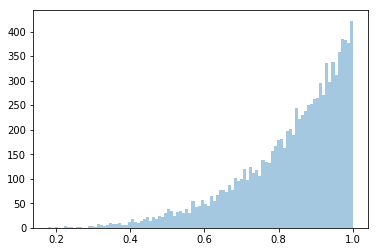

In [16]:
data_beta = beta.rvs(5, 1, size=10000)
sns.distplot(data_beta, kde=False, bins=100)
print('Mean probability {}'.format(np.mean(data_beta)))

In general we have good workers, on average the 90% of chances to getting the answer right

---

#### Summary of aggregated probabilities

In [17]:
df_tasks.groupby('label_task').agg(['mean','count'])

prob_task      
                mean count
label_task                
easy_task   0.871606   249
hard_task   0.620843   166

In [18]:
df_workers.describe()

,prob_worker
count,40.000000
mean,0.795465
std,0.161617
min,0.409390
25%,0.675975
50%,0.845601
75%,0.920319
max,0.994599


--- 

### Creating a task-worker assignation

this function has to eat btw the 2 df result from the previous functions

In [19]:
wpt = 5
#workers per task always smaller than the number of workers

In [3]:
import pandas as pd
import numpy as np

WPT = 3

class AssignTasks(object):
    def __init__(self, tasks, workers, wpt=WPT):
        self.wpt = wpt
        self.tasks = tasks
        self.workers = workers
    
    def _worker_assign(self):
        if self.wpt > len(self.workers):
            raise Exception('Number of workers per task must be smaller than the number of workers!')
        return [worker for i in [np.random.choice(self.workers.index, self.wpt, replace=False) for task in self.tasks.index] for worker in i]
    
    def _task_asssign(self):
        if self.wpt % 2 == 0:
            raise Exception('Number of workers per task must be odd!')
        return [item for k in [[self.tasks.index[i]]*self.wpt for i in range(len(self.tasks.index))] for item in k]
    
    def create(self):
        df = pd.DataFrame({'task_id':self._task_asssign(), 
                           'worker_id':self._worker_assign()})
        df = pd.merge(df, self.tasks, left_on='task_id', right_index=True, how='left')
        df = pd.merge(df, self.workers, left_on='worker_id', right_index= True, how='left')
        return df

In [21]:
df_tw = AssignTasks(df_tasks, df_workers, wpt).create()
df_tw.head()

,task_id,worker_id,true_answers,label_task,prob_task,prob_worker
0,task_pdS8zH,gqe73J,medals,easy_task,0.93,0.978348
1,task_pdS8zH,JzvUsB,medals,easy_task,0.93,0.662211
2,task_pdS8zH,d9s8F4,medals,easy_task,0.93,0.726437
3,task_pdS8zH,axyUud,medals,easy_task,0.93,0.848700
4,task_pdS8zH,QswzdS,medals,easy_task,0.93,0.424661


In [22]:
#aggregation of the tasks
_agg = df_tw.groupby('worker_id').agg('count')['task_id']
_agg.name = 'tasks'

In [23]:
# REVIEW THIS, HOW DO WE MAKE SURE ALL THE WORKERS HAVE TASK ASIGNATED
_agg.sort_values(ascending=False).head()

worker_id
d9s8F4    63
JzvUsB    61
zNJNPg    61
QswzdS    60
vdWqpq    60
Name: tasks, dtype: int64

---
### Probabilities of getting the answer right

w = worker answer correct  
T = Having knowledge to do the task


$$
P(w~|~T) = \frac{P(T~|~w) P(w)}{P(T~|~w) P(w) + P(T~|~w^c) P(w^c)}
$$

[Bayes for conditional probability example](http://www.stat.yale.edu/Courses/1997-98/101/condprob.htm)

Class propuse:  
Based on two vectors (pandas series same lenght) of probabilities create a conditional probability  
one vector for person, another for activity in this case workers and tasks
This new conditional prob is the prior probability for a Bernoulli likelihood  
Then the predicion will tell if the answer was right or not  

The Bernoulli is the posterior function to modelate the action

In [24]:
keys = df_tasks['true_answers'].unique()

In [25]:
keys

array(['medals', 'components', 'comments', 'feeders', 'calculation'],
      dtype=object)

In [4]:
import pandas as pd
from scipy.stats import bernoulli

class ComputeProbability(object):
    def __init__(self, series1, series2, keys, size=1):
        self.size = size
        self.series1 = series1
        self.series2 = series2
        self.keys = keys
        
    def _random_selection(self):
        return 1/len(self.keys)
    
    def _bayes_prob(self):
        if len(self.series1) != len(self.series2):
            raise Exception("Probability series expected to be the same size")
        return (self.series1*self.series2) / (self.series1*self.series2 + self._random_selection()*(1-self.series2))
    
    def predict(self):
        return pd.Series([bernoulli.rvs(size=self.size, p=prob)[0] for prob in self._bayes_prob()])

In [27]:
cp = ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)

In [5]:
import numpy as np

class WorkerAnswer(object):
    def __init__(self, series1, series2, keys):
        """
        series1 = vector of true values correspondet to 1
        series2 = vector of 1 and 0
        key = vector of odd number of strings
        """
        self.series1 = series1
        self.series2 = series2
        self.keys = keys
    
    def match(self):
        answers = []
        for idx, i in enumerate(self.series1):
            if i == 1:
                answers.append(self.series2.loc[idx])
            else:
                answers.append(np.random.choice([i for i in set(self.keys)-set(self.series2.loc[idx])], 1)[0])

        return answers 

In [29]:
worker_answer = WorkerAnswer(cp.predict(), df_tw['true_answers'], keys)

In [30]:
df_tw['worker_answers'] = worker_answer.match()

---
### Confusion Matrix for the answers

Based on [pycm](https://github.com/sepandhaghighi/pycm) analysis

In [31]:
from pycm import *

In [32]:
cm = ConfusionMatrix(df_tw['true_answers'].tolist(), df_tw['worker_answers'].tolist())

In [33]:
cm.matrix()

Predict          calculationcomments componentsfeeders  medals   
Actual
calculation      367      3        8        1        6        
comments         8        482      6        8        6        
components       6        4        349      7        4        
feeders          5        4        5        364      2        
medals           6        11       7        6        400      



In [34]:
cm.Overall_ACC

0.9455421686746988

In [35]:
cm.CrossEntropy

2.311353229546824

In [36]:
cm.ACC

{'calculation': 0.9792771084337349,
 'comments': 0.9759036144578314,
 'components': 0.9773493975903614,
 'feeders': 0.9816867469879518,
 'medals': 0.9768674698795181}

In [37]:
cm.FPR #False positive rate (FPR), Fall-out, probability of false alarm 

{'calculation': 0.014792899408283988,
 'comments': 0.014057507987220497,
 'components': 0.015249266862170097,
 'feeders': 0.012979351032448405,
 'medals': 0.010942249240121549}

In [38]:
cm.TPR #True positive rate (TPR), Recall, Sensitivity, probability of detection 

{'calculation': 0.9532467532467532,
 'comments': 0.9450980392156862,
 'components': 0.9432432432432433,
 'feeders': 0.9578947368421052,
 'medals': 0.9302325581395349}

In [39]:
cm.TNR #Specificity (SPC), Selectivity, True negative rate (TNR) 

{'calculation': 0.985207100591716,
 'comments': 0.9859424920127795,
 'components': 0.9847507331378299,
 'feeders': 0.9870206489675516,
 'medals': 0.9890577507598785}

In [40]:
cm.PPV #PPV(Precision or positive predictive value)   

{'calculation': 0.9362244897959183,
 'comments': 0.9563492063492064,
 'components': 0.9306666666666666,
 'feeders': 0.9430051813471503,
 'medals': 0.9569377990430622}

In [41]:
cm.FOR

{'calculation': 0.010695187165775444,
 'comments': 0.017823042647994947,
 'components': 0.012352941176470567,
 'feeders': 0.009473060982830073,
 'medals': 0.01810500905250456}

In [42]:
cm.F1

{'calculation': 0.9446589446589446,
 'comments': 0.9506903353057199,
 'components': 0.9369127516778524,
 'feeders': 0.9503916449086162,
 'medals': 0.9433962264150944}

Comparing with Turicreate library

In [43]:
import turicreate as tc
sf_tw = tc.SFrame(data=df_tw)
conf_matrix = tc.evaluation.confusion_matrix(sf_tw['true_answers'], sf_tw['worker_answers'])

In [44]:
conf_matrix.print_rows(25,)

+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
| calculation  |     feeders     |   1   |
|   feeders    |   calculation   |   5   |
|   feeders    |      medals     |   2   |
| calculation  |      medals     |   6   |
|  components  |      medals     |   4   |
|  components  |     comments    |   4   |
|   comments   |      medals     |   6   |
|    medals    |     feeders     |   6   |
|   comments   |     feeders     |   8   |
| calculation  |     comments    |   3   |
|   feeders    |     comments    |   4   |
|  components  |   calculation   |   6   |
|   feeders    |    components   |   5   |
| calculation  |    components   |   8   |
|  components  |     feeders     |   7   |
|    medals    |    components   |   7   |
| calculation  |   calculation   |  367  |
|    medals    |   calculation   |   6   |
|   comments   |    components   |   6   |
|   comments   |     comments    |  482  |
|   feeders

In [45]:
accuracy = conf_matrix[conf_matrix['target_label'] == conf_matrix['predicted_label']]['count'].sum() / conf_matrix['count'].sum()

In [46]:
print(accuracy)

0.9455421686746988


---
### Measuring Performance and split the good workers from the rest

Next we measure the performance of the worker. The performance is calculate as the number of times a worker answers right (in comparison with the true answer) over the total number of workers per task.  

The range of the performance value spans from 0 to 1. The values close to 1 indicate that the majority of the workers had consensus. The values close to 0 indicate that there was no consensus.

In [49]:
df_tw['performance'] = cp.predict()

In [43]:
import pandas as pd

IDX = 'worker_id'

class Performance(object):
    def __init__ (self, df_tw):
        self.df_tw = df_tw
        
    def _agg(self):
        df = self.df_tw.groupby(IDX).agg('count')['task_id']
        df.name = 'tasks'
        return df
    
    def _workers(self):
        df = self.df_tw.groupby(self.df_tw[IDX]).mean().sort_values('performance', ascending=False)
        df['worker_hability'] = ['good_worker' if i == 1 else 'poor_worker' for i in df['performance']]
        return df.join(self._agg(), on=IDX, how='left')
    
    def good_workers(self):
        _good = self._workers()[(self._workers()['worker_hability'] == 'good_worker') & ((self._workers()['prob_task'] < self._workers()['prob_task'].median()))] #& ((df['tasks'] > df['tasks'].median()))]
        #print('Selected Good Workers: {}'.format(good_workers['performance'].sum()))
        return [i for i in _good.index]

In [84]:
perf = Performance(df_tw)

In [88]:
perf._workers()

,prob_task,prob_worker,performance,worker_hability,tasks
worker_id,,,,,
3MB8n6,0.771064,0.956774,1.000000,good_worker,47
WJo9g8,0.780727,0.985452,1.000000,good_worker,55
wAjFWE,0.759200,0.940861,1.000000,good_worker,50
uNTazC,0.750351,0.932206,1.000000,good_worker,57
s5xwUM,0.821455,0.959641,1.000000,good_worker,55
pnkanh,0.736053,0.919292,1.000000,good_worker,38
oev8At,0.776087,0.985305,1.000000,good_worker,46
ipdqkr,0.757000,0.994599,1.000000,good_worker,60
iNf9Qg,0.779800,0.917399,1.000000,good_worker,50


Prediction Correct 1940 of 2075


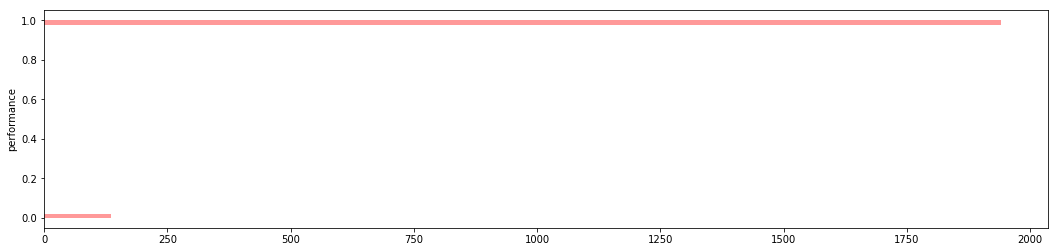

In [116]:
#Distribution performance
plt.figure(figsize=[18, 4])
sns.distplot(df_tw['performance'], kde=False, vertical=True, color="red")
print('Prediction Correct {} of {}'.format(df_tw['performance'].sum(), df_tw['performance'].count()))

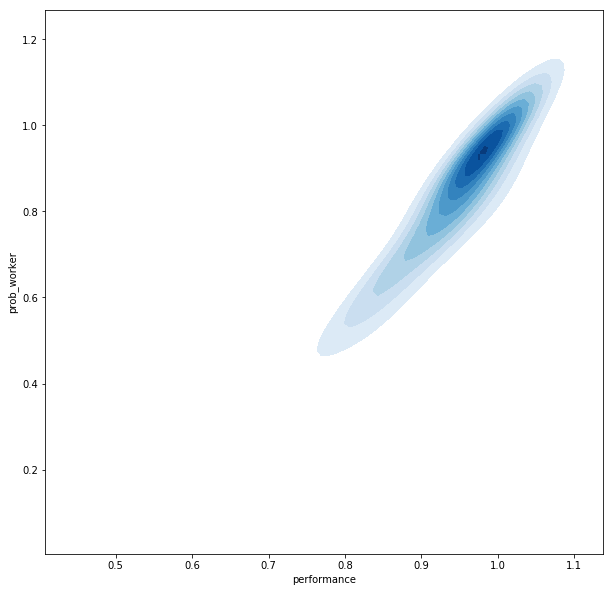

In [142]:
plt.figure(figsize=[10, 10])
sns.kdeplot(df_workers['performance'], df_workers['prob_worker'], cmap="Blues", shade=True, shade_lowest=False)

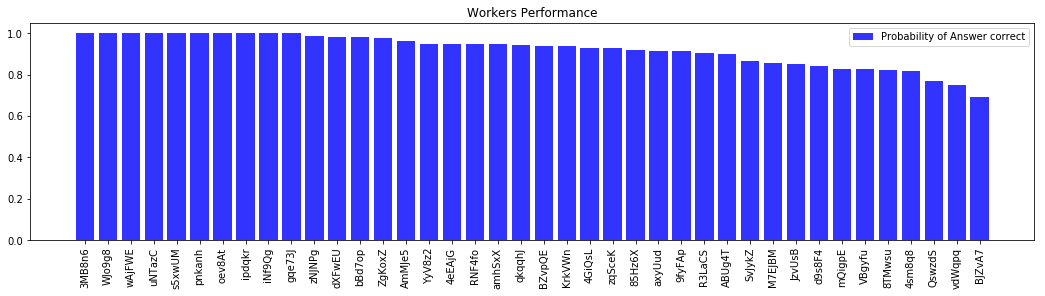

In [89]:
plt.figure(figsize=[18, 4])
axis = range(len(per._workers()))
plt.bar(axis, perf._workers()['performance'], align='center', alpha=0.8, color='blue', label='Probability of Answer correct')
plt.xticks(axis, perf._workers().index, rotation=90)
plt.title('Workers Performance')
plt.legend(loc='best')
plt.show()

In [90]:
perf._workers().describe()

,prob_task,prob_worker,performance,tasks
count,40.000000,40.000000,40.000000,40.000000
mean,0.771844,0.795465,0.920156,51.875000
std,0.021269,0.161617,0.079638,6.962123
min,0.736053,0.409390,0.689655,38.000000
25%,0.757037,0.675975,0.863415,46.750000
50%,0.771027,0.845601,0.941698,53.500000
75%,0.780032,0.920319,0.987705,57.000000
max,0.821455,0.994599,1.000000,63.000000


---
### Get Accuracy

In [92]:
import sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm

PTT = .3

def tasks_split(df, p=PTT):
    _train = df.sample(frac=p, random_state=23)
    _rest = df.loc[df.index.difference(_train.index)]
    return _train, _rest


def crowd_table(total_tasks=100, total_workers=30, p_hard_tasks=0.4, PTT=.3, wpt=5, NK=5):
    df_tasks = cs.Tasks(NK).create(total_tasks, p_hard_tasks)
    workers = cs.Workers().create(total_workers)
    keys = df_tasks['true_answers'].unique()
    tasks_train, tasks_rest = tasks_split(df_tasks, PTT)
    df_tw = cs.AssignTasks(tasks_train, workers, wpt).create()
    cp = cm.ComputeProbability(df_tw['prob_task'], df_tw['prob_worker'], keys)
    df_tw['worker_answers'] = cm.WorkerAnswer(
        cp.predict(), df_tw['true_answers'], keys).match()
    df_tw['performance'] = cp.predict()
    perf = cm.Performance(df_tw)
    good_workers = workers.loc[perf.good_workers()]
    df_tw_2 = cs.AssignTasks(tasks_rest, good_workers, wpt).create()
    cp2 = cm.ComputeProbability(
        df_tw_2['prob_task'], df_tw_2['prob_worker'], keys)
    df_tw_2['worker_answers'] = cm.WorkerAnswer(
        cp2.predict(), df_tw_2['true_answers'], keys).match()
    df_tw_2['performance'] = cp2.predict()
    df = df_tw.append(df_tw_2)
    return df